In [2]:
#libraries
import datetime as dt
import xarray as xr
import numpy as np
import fsspec
import s3fs
import os.path
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from osgeo import osr
from osgeo import gdal
import time as t
import datetime
from mpl_toolkits.basemap import Basemap
import cartopy
import cartopy.crs as ccrs

# make datasets display nicely
xr.set_options(display_style="html")  

#magic fncts #put static images of your plot embedded in the notebook
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 



In [3]:
#Load in zarr data
#%%time

file_location = 's3://ohw-bucket/goes_zarr'

ikey = fsspec.get_mapper(file_location,anon=False)

ds = xr.open_zarr(ikey) #,consolidated=True)

ds

,Array,Chunk
Bytes,31.07 GB,117.68 MB
Shape,"(264, 5424, 5424)","(1, 5424, 5424)"
Count,265 Tasks,264 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,31.07 GB,117.68 MB
Shape,"(264, 5424, 5424)","(1, 5424, 5424)"
Count,265 Tasks,264 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


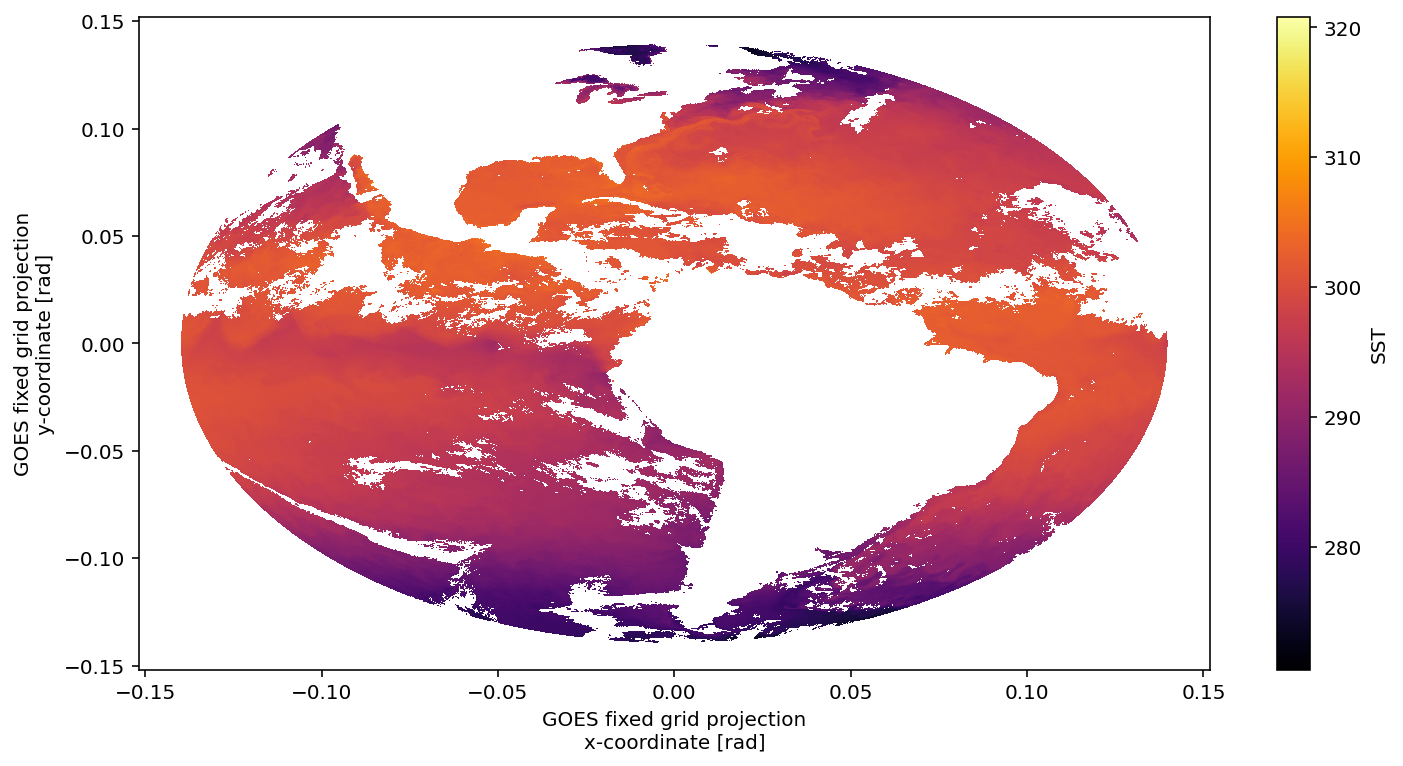

In [4]:
#Create basic plot (w/o sensible coords)
ds_subset = ds.isel(time=slice(0,24))
#gs_subset = ds_subset.sel(x=slice(0.0,0.020),y=slice(0.110,0.090))  #reduce to GS region
gs_subset = ds_subset
masked = gs_subset.SST.where(gs_subset.DQF==0)
mean_SST = masked.mean('time') 
mean_SST.plot(cmap='inferno')

In [5]:
#Convert x and y to coordinates
# GOES-R projection info and retrieving relevant constants
proj_info = ds.variables['goes_imager_projection']
#print(proj_info)
lon_origin = proj_info.attrs['longitude_of_projection_origin'][0]
H = proj_info.attrs['perspective_point_height'][0]+proj_info.attrs['semi_major_axis'][0]
r_eq = proj_info.attrs['semi_major_axis'][0]
r_pol = proj_info.attrs['semi_minor_axis'][0]

# Data info
lat_rad_1d = ds.variables['x'][:]
lon_rad_1d = ds.variables['y'][:]

# close file when finished
#g16nc.close()
#g16nc = None

# create meshgrid filled with radian angles
lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)

# lat/lon calc routine from satellite radian angle vectors

lambda_0 = (lon_origin*np.pi)/180.0

a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
c_var = (H**2.0)-(r_eq**2.0)

r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)

s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
s_y = - r_s*np.sin(lat_rad)
s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)

lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

#print(lat[0,0], lat[100,0])

#Change coordinates in xarray? 
#ds.coords['x'] = lon
#ds.coords['y'] = lat

# print test coordinates
print('{} N, {} W'.format(lat[318,1849],abs(lon[318,1849])))

<ipython-input-5-b2fbe92a8b91>:29: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


56.290740966796875 N, 107.58478546142578 W


-156.27083 6.2708173
-81.15669 81.15669


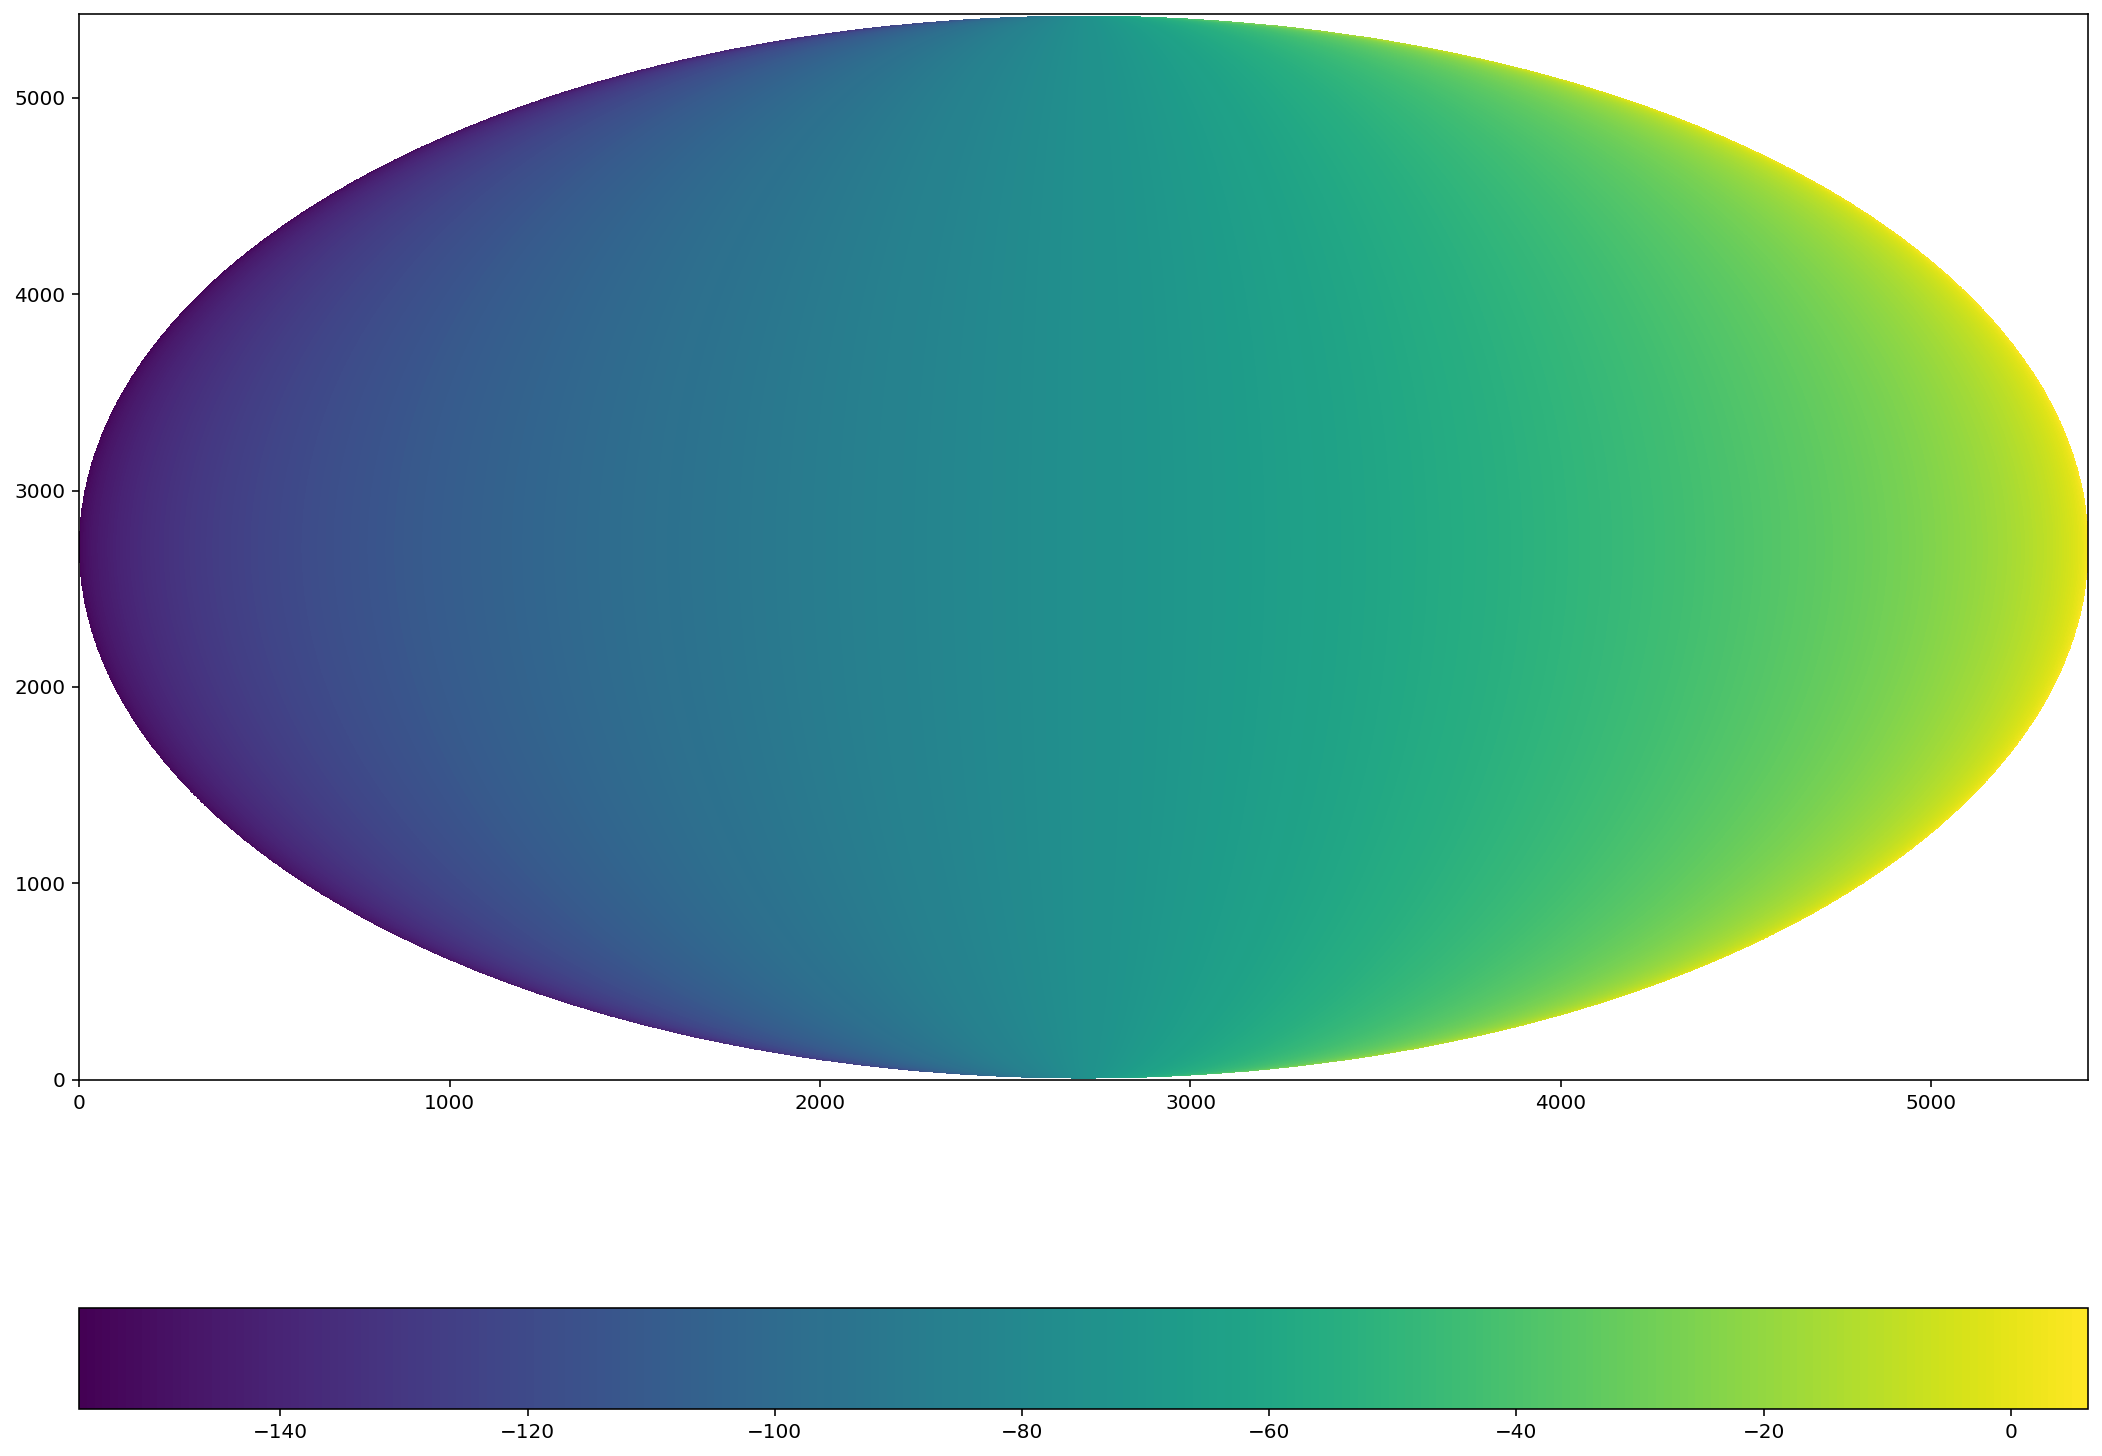

In [9]:
fig, ax1 = plt.subplots(figsize=((18,14)))
plt.pcolormesh(lon)
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(lon), vmax=np.nanmax(lon))
cax, _ = matplotlib.colorbar.make_axes(ax1, orientation="horizontal") #,pad=0.15)
cbar = matplotlib.colorbar.ColorbarBase(cax, norm=normalize,orientation="horizontal")
#plt.pcolormesh([ds.coords['x'], ds.coords['y']])
print(np.nanmin(lon), np.nanmax(lon))
print(np.nanmin(lat), np.nanmax(lat))

In [ ]:
#Create basic plot (w/o sensible coords)
ds_subset = ds.isel(time=slice(0,24))

#gs_subset = ds_subset.sel(x=slice(0.0,0.020),y=slice(0.110,0.090))  #reduce to GS region
gs_subset = ds_subset.isel(x=slice(0,4000),y=slice(0,4000))

masked = gs_subset.SST.where(gs_subset.DQF==0)
mean_SST = masked.mean('time') 
#mean_SST.plot(cmap='inferno')

lat_gs = lat[0:4000, 0:4000]
lon_gs = lon[0:4000, 0:4000]

#print(lat_gs.shape, lon_gs.shape, mean_SST.shape)

plt.pcolor(lon_gs, lat_gs, mean_SST, cmap='inferno')

#m = Basemap(projection='ortho',lat_0=45,lon_0=30)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-15-fb4b5766e2de>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(lon_gs, lat_gs, mean_SST, cmap='inferno')


In [8]:
gs_subset = ds_subset
masked = gs_subset.SST.where(gs_subset.DQF==0)
mean_SST = masked.mean('time') 
#mean_SST.plot(cmap='inferno')

#fig, ax1 = plt.subplots(figsize=((18,14)))
#ax1 = plt.subplot(projection=ccrs.Mollweide())
#ax1.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
#ax1.add_feature(cartopy.feature.LAND)
#gl = ax1.gridlines(draw_labels=False)
#plt.pcolormesh(lat, lon, mean_SST, cmap='inferno') #gives error as corners have nans
#plt.show()